In [ ]:
# -------------------------------
# 0. Install packages
# -------------------------------
!pip install transformers datasets scikit-learn plotly
!pip install evaluate

In [ ]:
# -------------------------------
# 1. Imports
# -------------------------------
import evaluate # Hugging Face now splits metrics into a separate package
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import plotly.express as px
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset

In [ ]:
# -------------------------------
# 2. Load CSVs
# -------------------------------
train_df = pd.read_csv("train_data.csv").dropna()
val_df   = pd.read_csv("val_data.csv").dropna()
test_df  = pd.read_csv("test_data.csv").dropna()

# Get all unique labels from training set
label_names = sorted(train_df['label'].unique())  # e.g. ['FAKE','REAL','NEUTRAL','OTHER']
label2id = {name: i for i, name in enumerate(label_names)}

# Apply mapping to all splits
for df in [train_df, val_df, test_df]:
    df['label'] = df['label'].map(label2id)

X_train = train_df['clean_text']
y_train = train_df['label'].values

X_val = val_df['clean_text']
y_val = val_df['label'].values

X_test = test_df['clean_text']
y_test = test_df['label'].values


# For Hugging Face dataset format
from datasets import Dataset

train_dataset = Dataset.from_dict({'clean_text': X_train, 'label': y_train})
val_dataset   = Dataset.from_dict({'clean_text': X_val, 'label': y_val})
test_dataset  = Dataset.from_dict({'clean_text': X_test, 'label': y_test})

In [ ]:
# -------------------------------
# 3. Quick test: Pretrained pipeline (no training)
# -------------------------------
from transformers import pipeline
classifier = pipeline("text-classification", model="distilbert-base-uncased", device=0)  # device=0 for GPU

sample_texts = ["The climate is changing faster than expected.", "Some claims about climate are fake."]
print("Quick predictions:", classifier(sample_texts))

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Device set to use cpu


Quick predictions: [{'label': 'LABEL_1', 'score': 0.5366244316101074}, {'label': 'LABEL_1', 'score': 0.5309561491012573}]


In [ ]:
import transformers
print(transformers.__version__)
print(TrainingArguments.__module__)
print(TrainingArguments.__init__.__code__.co_varnames)

4.56.0
transformers.training_args
('self', 'output_dir', 'overwrite_output_dir', 'do_train', 'do_eval', 'do_predict', 'eval_strategy', 'prediction_loss_only', 'per_device_train_batch_size', 'per_device_eval_batch_size', 'per_gpu_train_batch_size', 'per_gpu_eval_batch_size', 'gradient_accumulation_steps', 'eval_accumulation_steps', 'eval_delay', 'torch_empty_cache_steps', 'learning_rate', 'weight_decay', 'adam_beta1', 'adam_beta2', 'adam_epsilon', 'max_grad_norm', 'num_train_epochs', 'max_steps', 'lr_scheduler_type', 'lr_scheduler_kwargs', 'warmup_ratio', 'warmup_steps', 'log_level', 'log_level_replica', 'log_on_each_node', 'logging_dir', 'logging_strategy', 'logging_first_step', 'logging_steps', 'logging_nan_inf_filter', 'save_strategy', 'save_steps', 'save_total_limit', 'save_safetensors', 'save_on_each_node', 'save_only_model', 'restore_callback_states_from_checkpoint', 'no_cuda', 'use_cpu', 'use_mps_device', 'seed', 'data_seed', 'jit_mode_eval', 'use_ipex', 'bf16', 'fp16', 'fp16_opt

In [ ]:
# -------------------------------
# 4. Fine-tuning a pretrained model
# -------------------------------
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model     = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(np.unique(y_train)))

# Weighted Trainer to handle imbalance
import numpy as np
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from transformers import Trainer

# Compute class weights from training data
class_counts = np.bincount(y_train)  # count per numeric label
total = sum(class_counts)
weights = [total/c for c in class_counts]  # inverse frequency weighting
weights = torch.tensor(weights, dtype=torch.float)

class WeightedTrainer(Trainer):
    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        if class_weights is not None:
            self.class_weights = torch.tensor(class_weights, dtype=torch.float).to(self.model.device)
        else:
            self.class_weights = None

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        if self.class_weights is not None:
            loss_fct = nn.CrossEntropyLoss(weight=self.class_weights)
        else:
            loss_fct = nn.CrossEntropyLoss()

        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

import plotly.graph_objects as go

# Map back to label names
id2label = {i: name for name, i in label2id.items()}

freqs = class_counts.tolist()
wts   = weights.tolist()

fig = go.Figure(data=[
    go.Bar(name="Class Frequency", x=[id2label[i] for i in range(len(freqs))], y=freqs),
    go.Bar(name="Class Weight",    x=[id2label[i] for i in range(len(wts))], y=wts)
])

fig.update_layout(
    barmode='group',
    title="Class Frequencies vs. Weights",
    xaxis_title="Label",
    yaxis_title="Value",
    template="plotly_white"
)

fig.show()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:

# Tokenization
def tokenize(batch):
    return tokenizer(batch["clean_text"], padding=True, truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset   = val_dataset.map(tokenize, batched=True)
test_dataset  = test_dataset.map(tokenize, batched=True)

train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
    learning_rate=1e-5,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none"   # <-- disables wandb, tensorboard, etc.
)

Map:   0%|          | 0/1074 [00:00<?, ? examples/s]

Map:   0%|          | 0/230 [00:00<?, ? examples/s]

Map:   0%|          | 0/231 [00:00<?, ? examples/s]

In [ ]:
from evaluate import load

# Metric computation
accuracy = load("accuracy")
precision = load("precision")
recall = load("recall")
f1 = load("f1")

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    refs = p.label_ids # truth

    acc = accuracy.compute(predictions=preds, references=refs)
    prec = precision.compute(predictions=preds, references=refs, average="weighted")
    rec = recall.compute(predictions=preds, references=refs, average="weighted")
    f1_score = f1.compute(predictions=preds, references=refs, average="weighted")

    return {
        "accuracy": acc["accuracy"],
        "precision": prec["precision"],
        "recall": rec["recall"],
        "f1": f1_score["f1"]
    }

In [ ]:
# Trainer
trainer = Trainer(
# trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

/tmp/ipython-input-1415767554.py:2: FutureWarning:

`tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.



In [ ]:
# -------------------------------
# 5. Train / fine-tune
# -------------------------------
trainer.train()

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning:

'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.



Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.303500,1.226622,0.430435,0.185274,0.430435,0.259046
2,1.257600,1.205843,0.430435,0.306786,0.430435,0.280998
3,1.286300,1.185205,0.460870,0.342435,0.460870,0.373352
4,1.188400,1.170934,0.460870,0.343073,0.460870,0.386634
5,1.110900,1.168239,0.473913,0.352833,0.473913,0.393643


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning:

'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning:

'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precis

TrainOutput(global_step=340, training_loss=1.2192370639127843, metrics={'train_runtime': 2022.1852, 'train_samples_per_second': 2.656, 'train_steps_per_second': 0.168, 'total_flos': 98102851941024.0, 'train_loss': 1.2192370639127843, 'epoch': 5.0})

In [ ]:
# -------------------------------
# 6. Evaluation on test set
# -------------------------------
preds_output = trainer.predict(test_dataset)
y_pred = np.argmax(preds_output.predictions, axis=1)

# Bring back original labels
id2label = {v:k for k,v in label2id.items()}
y_test_labels = [id2label[i] for i in y_test]
y_pred_labels = [id2label[i] for i in y_pred]

print(classification_report(y_test_labels, y_pred_labels, zero_division=0))

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning:

'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

    DISPUTED       0.00      0.00      0.00        17
     NEUTRAL       0.38      0.29      0.33        69
     REFUTES       0.00      0.00      0.00        30
    SUPPORTS       0.52      0.81      0.63       115

    accuracy                           0.49       231
   macro avg       0.23      0.27      0.24       231
weighted avg       0.37      0.49      0.41       231



In [ ]:
# -------------------------------
# 7. Confusion Matrix
# -------------------------------
from viz import *
cm = confusion_matrix(y_test_labels, y_pred_labels)
cm_df = pd.DataFrame(cm, index=np.unique(y_test_labels), columns=np.unique(y_test_labels))

fig = px.imshow(cm_df,
                text_auto=True,
                labels=dict(x="Predicted", y="Actual", color="Count"),
                color_continuous_scale="Blues",
                title="Confusion Matrix")
fig.show()

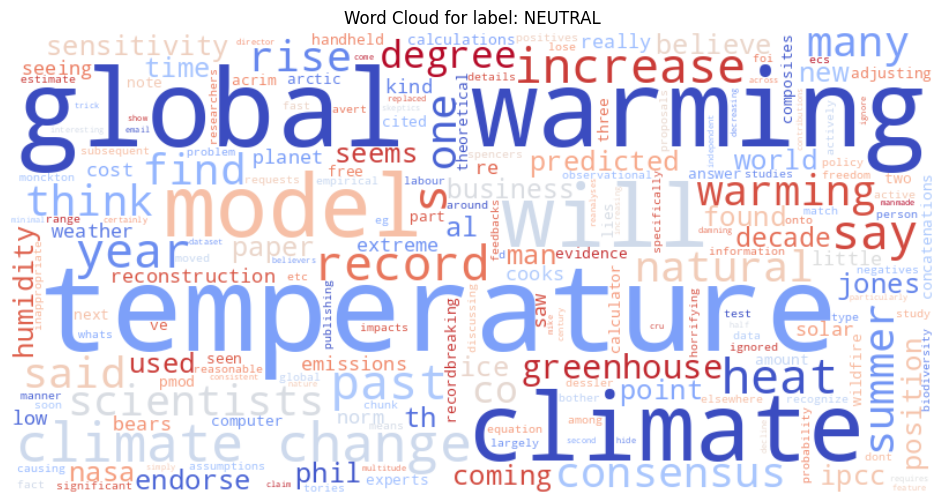

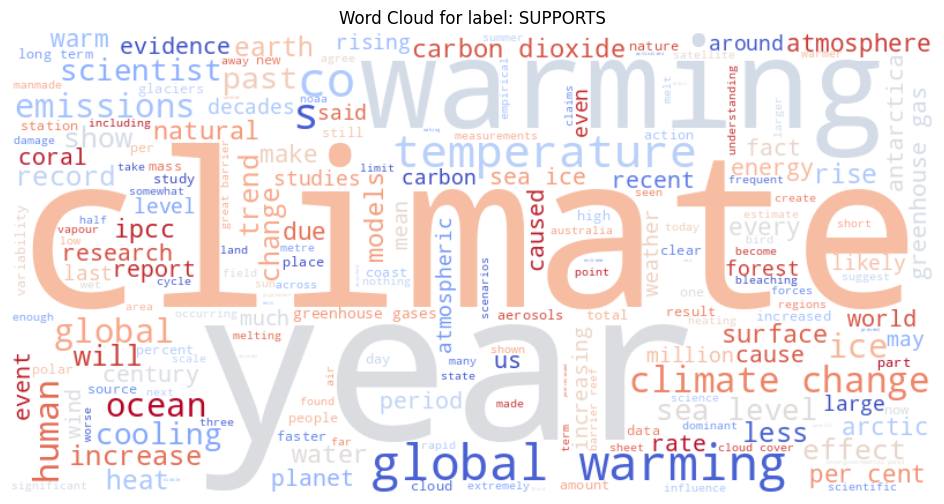

In [ ]:
# -------------------------------
# 8. Word Clouds for each label
# -------------------------------
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# First, create a DataFrame with text + predicted label
test_texts = test_df["clean_text"].tolist()
pred_labels = y_pred_labels

df_pred = pd.DataFrame({
    "text": test_texts,
    "pred": pred_labels
})

label_names = np.unique(y_pred_labels)

# Generate a word cloud per label
for lbl in label_names:
    texts = " ".join(df_pred[df_pred["pred"]==lbl]["text"])

    # Create the word cloud
    wc = WordCloud(width=800, height=400, background_color="white", colormap="coolwarm").generate(texts)

    plt.figure(figsize=(12,6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for label: {lbl}")
    plt.show()

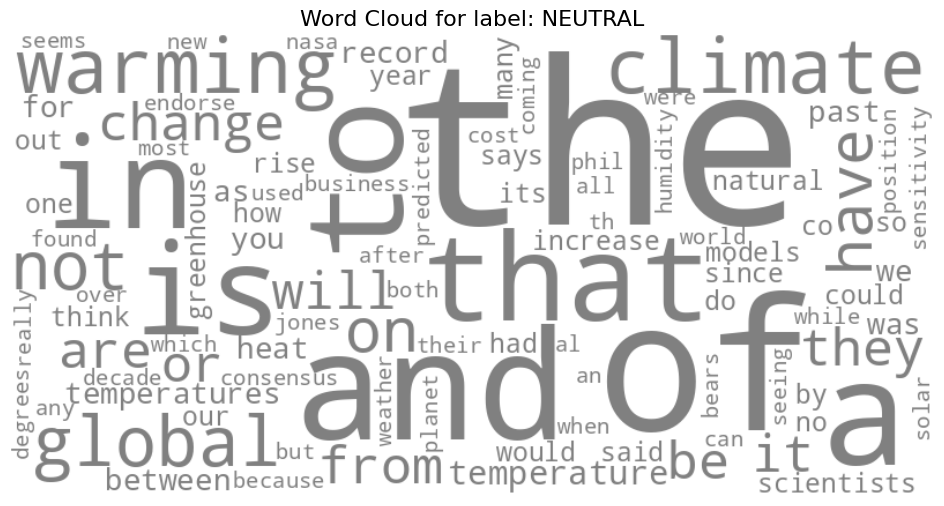

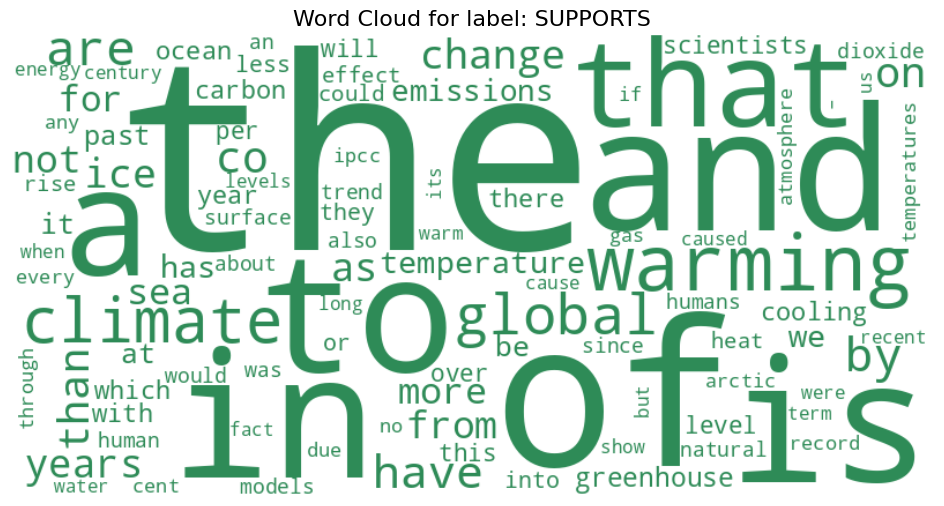

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

df_pred = pd.DataFrame({
    "text": test_texts,
    "pred": y_pred_labels
})

# Colors per label
label_colors = {
    "SUPPORTS": "seagreen",
    "REFUTES": "crimson",
    "NEUTRAL": "gray",
    "DISPUTED": "orange"
}

for lbl in np.unique(y_pred_labels):
    texts = " ".join(df_pred[df_pred["pred"]==lbl]["text"])
    if not texts.strip():
        print(f"No predictions for label {lbl}, skipping word cloud.")
        continue

    word_freq = Counter(texts.split())

    wc = WordCloud(
        width=800,
        height=400,
        background_color="white",
        max_words=100,
        color_func=lambda *args, **kwargs: label_colors[lbl]  # pass label directly here
    ).generate_from_frequencies(word_freq)

    plt.figure(figsize=(12,6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for label: {lbl}", fontsize=16)
    plt.show()